In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
%matplotlib inline

In [2]:
data = pd.read_csv('data/ratings.csv')
data.drop('timestamp', axis=1, inplace=True)
data = data.dropna()
data['movieId'] = data['movieId'].astype('int64')
print(len(data))
data.head(2)

26024289


,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5


In [3]:
movies_data = pd.read_csv('data/movies_metadata.csv')
movies_data = movies_data.rename(columns={"id": "movieId"})
print(len(movies_data))
movies_data.head(2)

45466


C:\Users\ksn\AppData\Local\Temp\ipykernel_8724\1554198658.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_data = pd.read_csv('data/movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [4]:
movies = movies_data.copy()

for i in movies_data.index:
    if re.findall('-', movies_data.iloc[i]['movieId']):
        movies.drop(i, inplace=True)

movies['movieId'] = movies['movieId'].astype('int64')

In [5]:
my_ratings = pd.read_csv('ratings.csv')
print(len(my_ratings))
my_ratings = my_ratings.rename(columns={"Const": "imdb_id", "Your Rating": "rating"})
my_ratings.head(2)

144


,imdb_id,rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors
0,tt1014759,9,2023-12-21,Alice in Wonderland,https://www.imdb.com/title/tt1014759/,movie,6.4,108,2010,"Adventure, Family, Fantasy, Mystery",435437,2010-02-25,Tim Burton
1,tt0103639,9,2023-12-14,Aladdin,https://www.imdb.com/title/tt0103639/,movie,8.0,90,1992,"Animation, Adventure, Comedy, Family, Fantasy,...",456675,1992-11-08,"Ron Clements, John Musker"


In [6]:
my = my_ratings[['imdb_id', 'rating']].copy()
my['userId'] = 400000
ids = movies[['movieId', 'imdb_id']]
my = my.merge(ids, how='left', on='imdb_id')
my.drop('imdb_id', axis=1, inplace=True)
my.index = my['movieId']
my.head(2)

,rating,userId,movieId
movieId,,,
12155.0,9,400000,12155.0
812.0,9,400000,812.0


delete movies from the data that are not in the table 'movies'

In [7]:
delta = set(data['movieId']) - set(movies['movieId'])
data_train = data.loc[~data['movieId'].isin(delta)]
len(data_train)

11436568

In [8]:
genres = []

for i in range(len(movies)):
    genres.extend(list(map(lambda x: x[9:], re.findall("'name': '\w*", movies.iloc[i]['genres']))))

colms = list(set(genres))

df_genres = pd.DataFrame(columns=colms)
df_genres['movieId'] = movies['movieId']
df_genres = df_genres.fillna(0)
df_genres.index = df_genres['movieId']
df_genres.drop('movieId', axis=1, inplace=True)

for i in df_genres.index:
    genres = list(map(lambda x: x[9:], re.findall("'name': '\w*", str(movies.loc[movies['movieId'] == i]['genres']))))
    for j in genres:
        df_genres.at[i, j] = 1

sum_col = [sum(df_genres[i]) for i in df_genres.columns]

for i in df_genres.columns:
    if sum(df_genres[i]) < np.percentile(np.array(sum_col), 10):
        try:
            df_genres.drop(i, axis=1, inplace=True)
        except KeyError:
            pass

df_genres.head(3)

,Action,Drama,Horror,Mystery,Romance,Science,Western,Fantasy,Comedy,Music,Adventure,Thriller,Documentary,War,TV,Animation,Family,Crime
movieId,,,,,,,,,,,,,,,,,,
862,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8844,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
15602,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
selected_genres = list(df_genres.loc[df_genres['Comedy'] == 1].index)

data_train = data_train.loc[data_train['movieId'].isin(selected_genres)]
my = my.loc[my['movieId'].isin(selected_genres)]
len(data_train)

1993834

limit by years

In [10]:
max_year = 9999
min_year = 1930

movieId = []
year = []

for i in movies['movieId']:
    movieId.append(i)
    try:
        year.append(int(re.findall('[0-9]{4}-', str(movies.loc[movies['movieId'] == i]['release_date']))[0][0:4]))
    except IndexError:
        year.append(8888)

df_year = pd.DataFrame({'movieId': movieId, 'year': year})
df_year = df_year.loc[(df_year['year'] < max_year)&(df_year['year'] > min_year)]

data_train = data_train.loc[data_train['movieId'].isin(df_year['movieId'])]
my = my.loc[my['movieId'].isin(df_year['movieId'])]
len(data_train)

1974983

In [11]:
countries = []

for i in movies.index:
    try:
        c = movies['production_countries'][i].replace("}, {", "}]comma[{").split('comma')
    except AttributeError:
        pass

    if len(c) > 1:
        for j in c:
            if j[17:19] not in ('CI', 'LA'):
                countries.append(json.loads(j.replace("\'", "\"")[1:-1])['name'])
                movies.at[i, 'countries'] = json.loads(j.replace("\'", "\"")[1:-1])['name']
    if len(c[0]) > 2:
        if c[0][17:19] not in ('CI', 'LA'):
            countries.append(json.loads(c[0].replace("\'", "\"")[1:-1])['name'])
            movies.at[i, 'countries'] = json.loads(c[0].replace("\'", "\"")[1:-1])['name']

In [12]:
# from collections import Counter

# pd.DataFrame(Counter(countries).items()).sort_values(1, ascending=False)[:20]

In [13]:
# selected_countries = list(movies.loc[(movies['countries'] == 'Soviet Union')|(movies['countries'] == 'Russia')]['movieId'])
# selected_countries = list(movies.loc[movies['countries'] == 'France']['movieId'])

# data_train = data_train.loc[data_train['movieId'].isin(selected_countries)]
# my = my.loc[my['movieId'].isin(selected_countries)]
# len(data_train)

### reducing amount of data

In [14]:
popularity_movie = data_train.groupby('movieId')['rating'].count().reset_index().sort_values('rating', ascending=False)
popularity_movie['rating_rank'] = popularity_movie['rating'].rank()
popularity_movie.drop('rating', axis=1, inplace=True)
popularity_movie.head(3)

,movieId,rating_rank
60,480,1319.0
259,2959,1318.0
98,858,1317.0


In [15]:
data_train = pd.merge(data_train, popularity_movie, how='left', on='movieId')

In [16]:
user_sum_rating = data_train.groupby('userId')['rating_rank'].sum().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_sum_rating.head(3)

,userId,rating_rank
0,8659,525839.5
1,45811,495575.0
2,179792,485231.0


In [17]:
user_count_rating = data_train.groupby('userId')['rating_rank'].count().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_count_rating.head(3)

,userId,rating_rank
0,45811,650
1,8659,573
2,179792,481


In [18]:
user_rating = pd.merge(user_sum_rating, user_count_rating, how='left', on='userId')
user_rating['rating_rank'] = user_rating['rating_rank_x']/user_rating['rating_rank_y']
user_rating.drop(['rating_rank_x', 'rating_rank_y'], axis=1, inplace=True)
user_rating.head(3)

,userId,rating_rank
0,8659,917.695462
1,45811,762.423077
2,179792,1008.796258


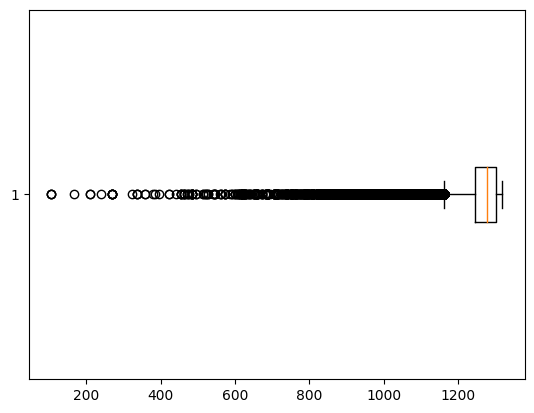

In [19]:
plt.boxplot(user_rating['rating_rank'], vert=False)
plt.show()

selected interquartile range 

In [20]:
data_train_0 = data_train.copy()

In [21]:
def iqr_selecter(Q, data_train):
    Q1 = user_rating['rating_rank'].quantile(0.1)
    Q3 = user_rating['rating_rank'].quantile(Q)
    print(f'Q1={Q1}, Q3={Q3}')
    user_rating_iqr = user_rating.loc[(user_rating['rating_rank'] < Q3) & (user_rating['rating_rank'] > Q1)]
    user_list = user_rating_iqr['userId'].tolist()
    data_train = data_train.loc[data_train['userId'].isin(user_list)]
    data_train = pd.concat([data_train, my], ignore_index=True)
    print(len(data_train))
    return data_train.groupby('movieId').sum().sort_values('rating_rank', ascending=False).index[:250]

user_list30 = iqr_selecter(0.3, data_train_0)
user_list60 = iqr_selecter(0.6, data_train_0)
user_list20 = iqr_selecter(0.2, data_train_0)
user_list15 = iqr_selecter(0.15, data_train_0)

# plt.boxplot(user_rating_iqr['rating_rank'], vert=False)
# plt.show()

Q1=1204.6666666666667, Q3=1254.357142857143
645093
Q1=1204.6666666666667, Q3=1287.7
1223130
Q1=1204.6666666666667, Q3=1236.4166666666667
355823
Q1=1204.6666666666667, Q3=1223.8823529411766
190378


In [22]:
my = my.loc[my['rating'] > 6]
my_genres = df_genres[df_genres.index.isin(my['movieId'])].mean().values

def rec_final(rec):
    name = []
    date = []
    url = []
    als_score = []
    score_imdb = []
    corr = []

    for i in rec:
        name.append(movies.loc[movies['movieId'] == i]['original_title'].values[0])
        date.append(movies.loc[movies['movieId'] == i]['release_date'].values[0])
        url.append('https://www.imdb.com/title/' + str(movies.loc[movies['movieId'] == i]['imdb_id'].values[0]))
        score_imdb.append(movies.loc[movies['movieId'] == i]['vote_average'].values[0])
        corr.append(0)
        if df_genres.loc[int(i)].sum().any() != 0:
            corr[-1] = (np.corrcoef(my_genres, df_genres.loc[int(i)])[0, 1])

    df =  pd.DataFrame({'name': name, 'date': date, 'url': url, 'score imdb': score_imdb, 'correlation': corr})
    df['rank'] = df['score imdb'].rank()
    df = df.sort_values('rank', ascending=False)
    return df

In [23]:
movies_ranked = movies.loc[movies['movieId'].isin(selected_genres)]
movies_ranked = movies_ranked[['movieId', 'vote_average', 'vote_count']].copy()
movies_ranked['rank'] = movies_ranked['vote_average'].rank() + movies_ranked['vote_count'].rank()
rec_final(movies_ranked.sort_values('rank', ascending=False)['movieId'][:250]).to_html('Comedy popular movies by rank.html', encoding='utf-8', index=False, render_links=True)

In [24]:
def create_html(x, Q):
    if len(x) != 0:
        return rec_final(x)\
        .to_html(f'Comedy popular movies from users dataset(Q={Q}).html', encoding='utf-8', index=False, render_links=True)

In [25]:
create_html(user_list60, 0.6)
create_html(user_list30, 0.3)
create_html(user_list20, 0.2)
create_html(user_list15, 0.15)

In [26]:
create_html(list(set(user_list60) - set(user_list30)), '0.6-0.3')
create_html(list(set(user_list60) - set(user_list20)), '0.6-0.2')
create_html(list(set(user_list60) - set(user_list15)), '0.6-0.15')

In [27]:
create_html(list(set(user_list30) - set(user_list20)), '0.3-0.2')
create_html(list(set(user_list30) - set(user_list15)), '0.3-0.15')

In [28]:
create_html(list(set(user_list20) - set(user_list15)), '0.2-0.15')